In [1]:
! pip install 'cebra[dev,demos]' 

/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: No such file or directory
/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: exec: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: cannot execute: No such file or directory


In [2]:
import sys
import os # my addtion

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

from scipy.integrate import solve_ivp
import cebra.datasets
from cebra import CEBRA
import torch
import d_library as dl


/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/lib/python3.11/site-packages/cebra/datasets/__init__.py:103: UserWarning: Could not initialize one or more datasets: No module named 'h5py'. For using the datasets, consider installing the [datasets] extension via pip.
  warnings.warn(f"Could not initialize one or more datasets: {e}. "


## Lorenz Attractor Analysis

In this capsule, we will run a dimension reduction analysis on the lorenz attractor.

In [3]:
# set max iterations
iterations = 1000

In [14]:
# Make a function to build a model, train it and then compute an embedding

def get_embed(input, dimension=3):

    # build CEBRA time model
    model = CEBRA(model_architecture='offset1-model',
                         batch_size=512,
                         learning_rate=0.01,
                         temperature=1,
                         output_dimension = int(dimension),
                         max_iterations=iterations,
                         distance='euclidean',
                         conditional='time',
                         device='cuda_if_available',
                         num_hidden_units=64,
                         verbose=True,
                         time_offsets=1)

    model.fit(input)
    embedding = model.transform(input)


    return model, embedding


In [5]:
# define a function to make a lorenz system
def lorenz(t, xyz, sigma=10, rho=28, beta=8/3):
    x, y, z = xyz
    dxdt = sigma * (y - x)
    dydt = rho * x - y - x * z
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

In [6]:
# Define parameters and initial conditions
sigma = 10
rho = 28
beta = 8/3
initial_conditions = [0, 2, 0]  # Initial conditions for [x, y, z]

# Time span for integration
t_span = [0, 35]

In [7]:
# Solve the differential equations
solution = solve_ivp(lorenz, t_span, initial_conditions, args=(sigma, rho, beta), dense_output=True)

# Generate time points for plotting
t = np.linspace(t_span[0], t_span[1], 10000)

In [8]:
# Evaluate the solution at the time points
xyz = solution.sol(t)

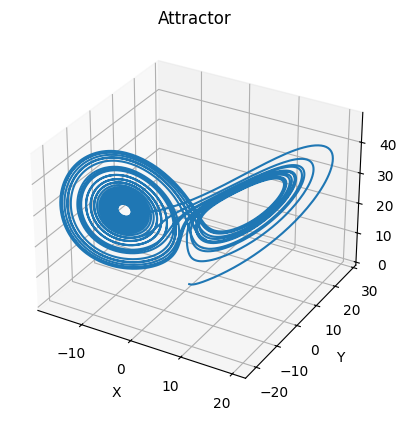

In [9]:
%matplotlib inline
# Plot the Lorenz attractor
def plot_lorenz(coords):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(coords[0], coords[1], coords[2], alpha=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Attractor')
    plt.show()


plot_lorenz(xyz)

In [10]:
# check the shape of the object
xyz.shape

(3, 10000)

In [11]:
# reshape it for use with cebra
lorenz_obj = xyz.reshape(10000,3)
lorenz_obj.shape

(10000, 3)

In [15]:
# now get embeddings with different output dimensions
model_l1, embed_l1 = get_embed(lorenz_obj, dimension=1)
model_l2, embed_l2 = get_embed(lorenz_obj, dimension=2)
model_l3, embed_l3 = get_embed(lorenz_obj, dimension=3)
model_l4, embed_l4 = get_embed(lorenz_obj, dimension=4)
model_l5, embed_l5 = get_embed(lorenz_obj, dimension=5)
model_l8, embed_l8 = get_embed(lorenz_obj, dimension=8)


pos:  0.0000 neg:  6.2383 total:  6.2383 temperature:  1.0000: 100%|██████████| 1000/1000 [00:12<00:00, 79.65it/s]
pos:  0.0054 neg:  5.0695 total:  5.0750 temperature:  1.0000: 100%|██████████| 1000/1000 [00:11<00:00, 85.87it/s]
pos:  0.0213 neg:  4.8417 total:  4.8630 temperature:  1.0000: 100%|██████████| 1000/1000 [00:11<00:00, 85.57it/s]
pos:  0.0104 neg:  4.7238 total:  4.7341 temperature:  1.0000: 100%|██████████| 1000/1000 [00:12<00:00, 83.25it/s]
pos:  0.0155 neg:  4.6371 total:  4.6526 temperature:  1.0000: 100%|██████████| 1000/1000 [00:11<00:00, 84.39it/s]
pos:  0.0188 neg:  4.5007 total:  4.5195 temperature:  1.0000: 100%|██████████| 1000/1000 [00:11<00:00, 85.88it/s]


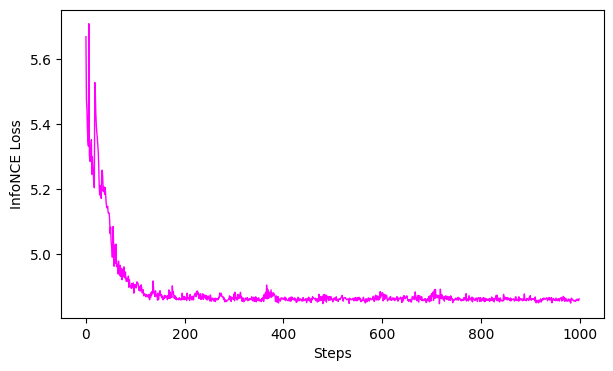

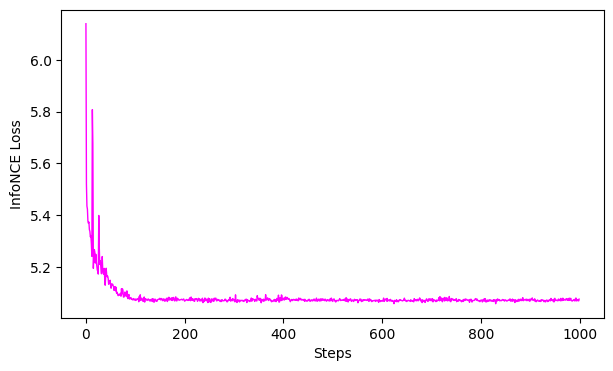

In [16]:
# display the loss of the models during training
ax = cebra.plot_loss(model_l3)
ax1 = cebra.plot_loss(model_l2)

<Axes: title={'center': 'Embedding'}>

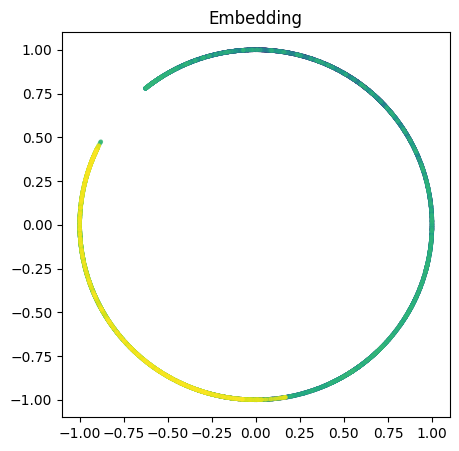

In [17]:
# Let's visualize them
cebra.plot_embedding(embedding=embed_l2, embedding_labels='time', markersize=5)

<Axes3D: title={'center': 'Embedding'}>

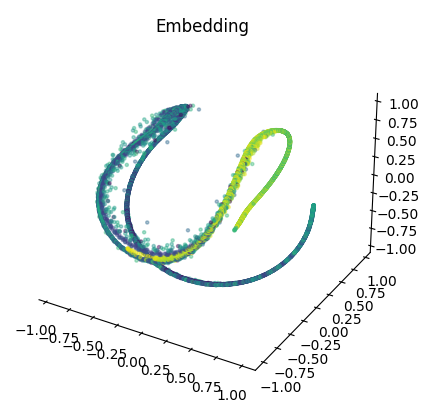

In [18]:
cebra.plot_embedding(embedding=embed_l3, embedding_labels='time', markersize=5)

<Axes3D: title={'center': 'Embedding'}>

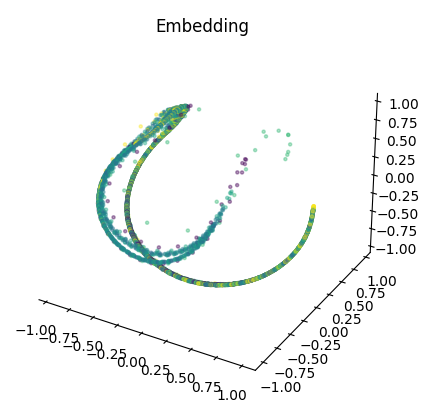

In [19]:
cebra.plot_embedding(embedding=embed_l3[0:5000,:], embedding_labels='time', markersize=5)

In [20]:
lorenz_input = [lorenz_obj]

In [21]:
# Create a grid of 2 rows and 3 columns
def embed_attractor(attractor):

   # get embeddings in 2D and 3D
   attractor_input = attractor.reshape(attractor.shape[1],attractor.shape[0])
   model_pl2, embed_pl2 = get_embed(attractor_input, dimension=2)
   model_pl3, embed_pl3 = get_embed(attractor_input, dimension=3)

   for i in range(0,attractor.shape[1],1000):

        attractor_p = attractor[:,0:i+1000]

        # define the grid
        gs = gridspec.GridSpec(2, 2, figure=plt.figure(figsize=(10,10)))

        # plot portion of attractor
        ax1 = plt.subplot(gs[0, :], projection='3d')  
        ax1.plot(attractor_p[0], attractor_p[1], attractor_p[2], alpha=1)
        plt.title('Timestep {}'.format(i+1000))

        # plot embeddings
        ax2 = plt.subplot(gs[1,0])
        cebra.plot_embedding(embedding=embed_pl2[0:i+1000,:], embedding_labels='time', markersize=5, ax=ax2, title='2D')
        ax3 = plt.subplot(gs[1,1], projection='3d')
        cebra.plot_embedding(embedding=embed_pl3[0:i+1000,:], embedding_labels='time', markersize=5,ax=ax3, title='3D')
        
        plt.show()


pos:  0.0063 neg:  5.0650 total:  5.0713 temperature:  1.0000: 100%|██████████| 1000/1000 [00:11<00:00, 86.89it/s]
pos:  0.0111 neg:  4.8420 total:  4.8531 temperature:  1.0000: 100%|██████████| 1000/1000 [00:11<00:00, 90.06it/s]


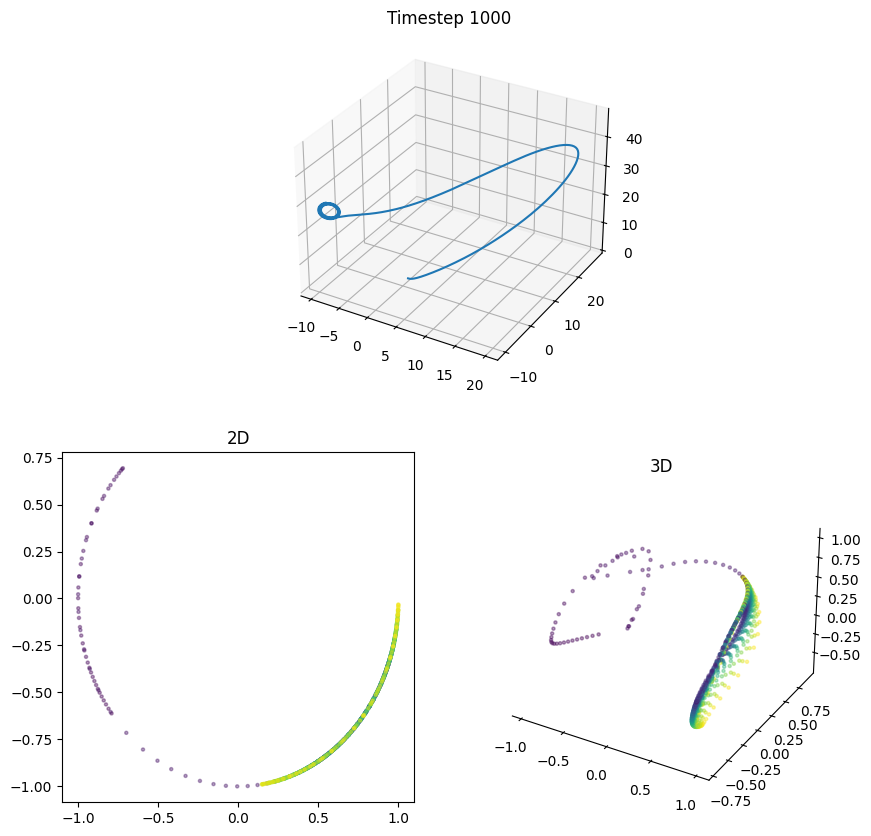

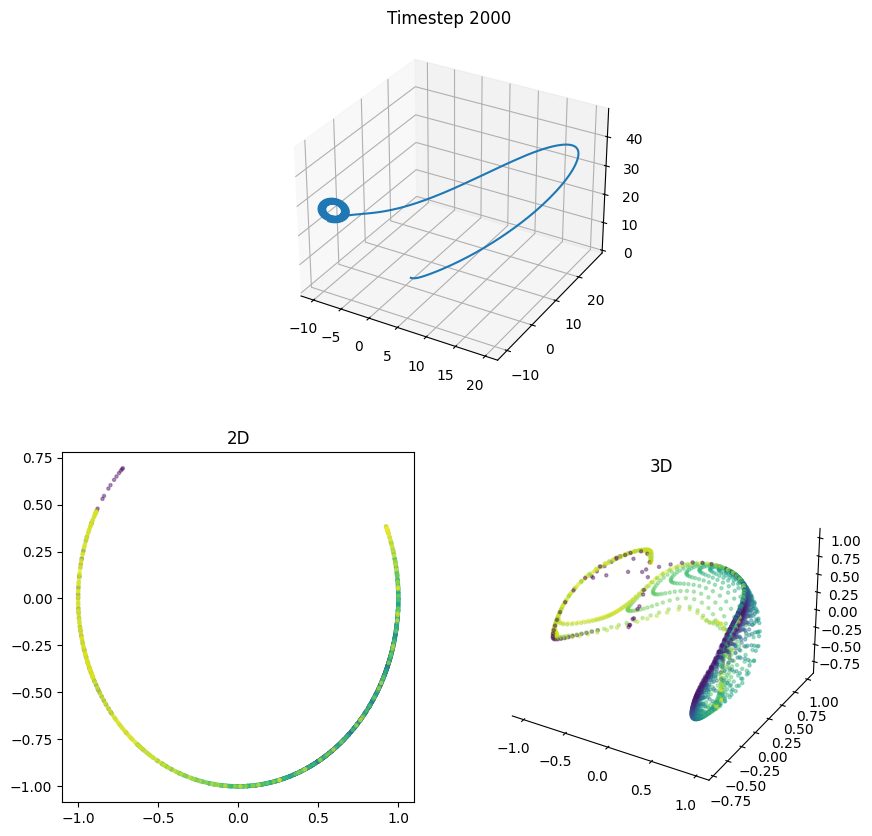

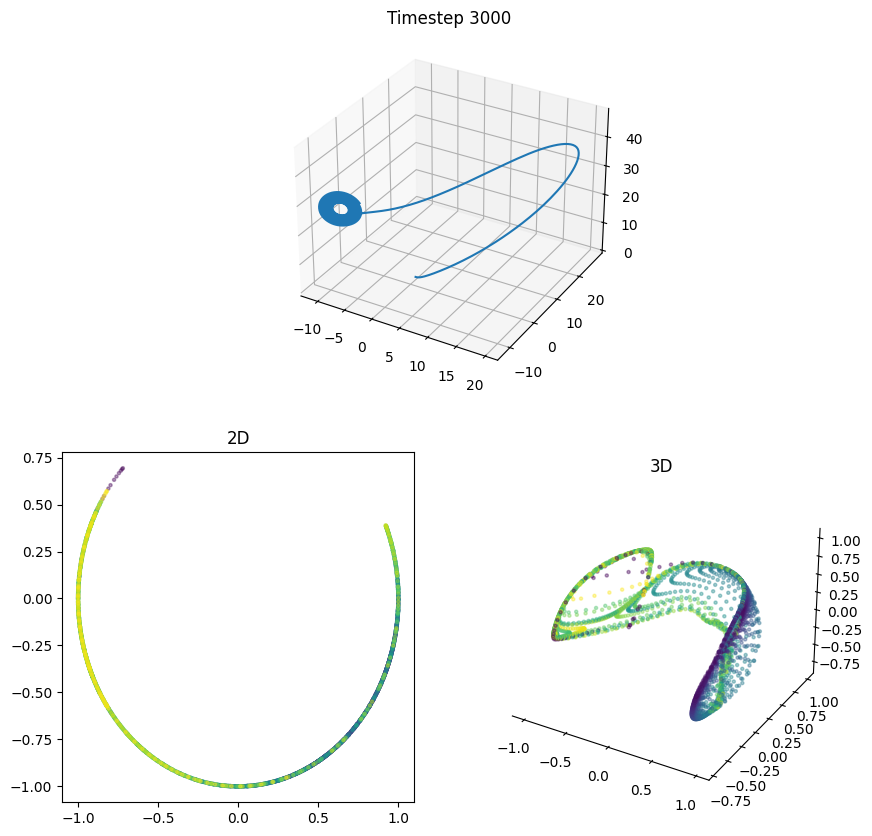

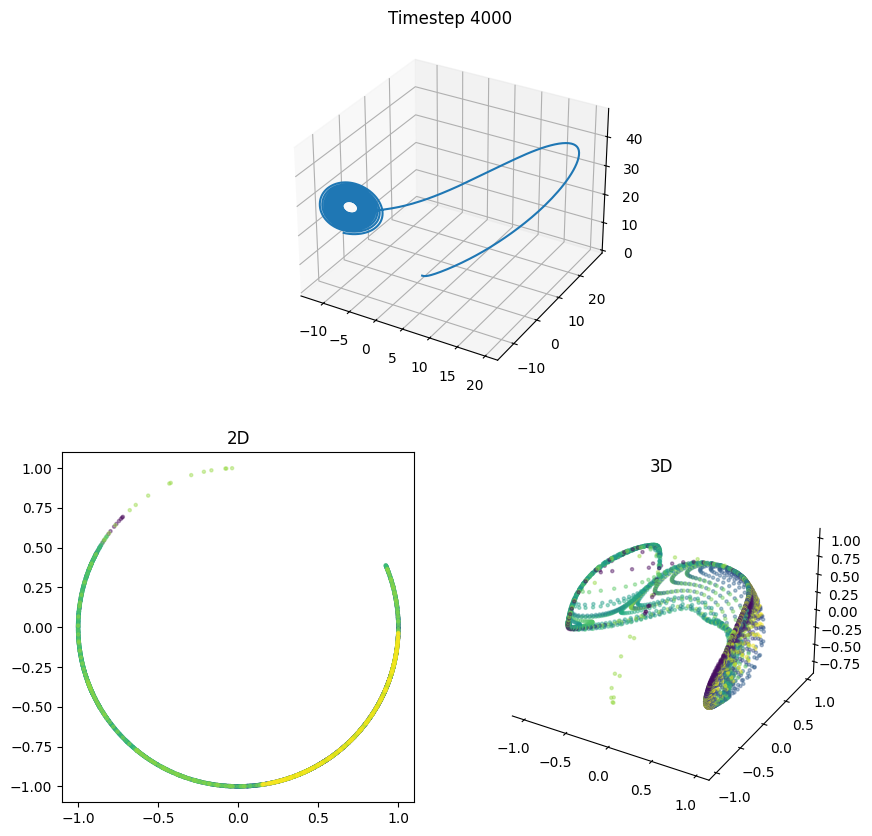

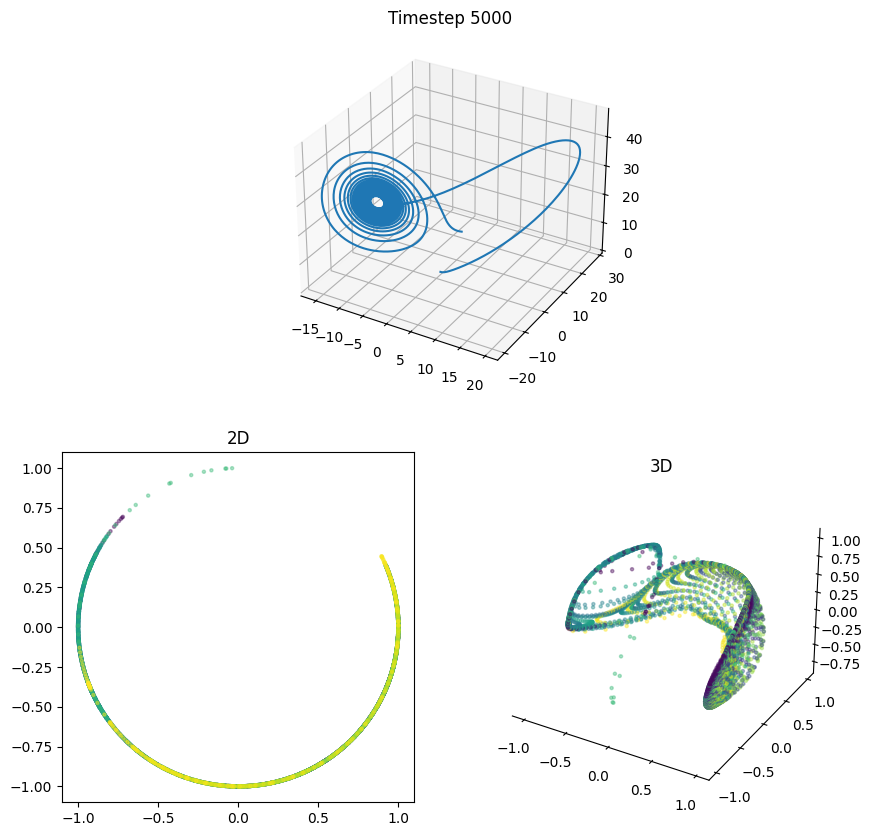

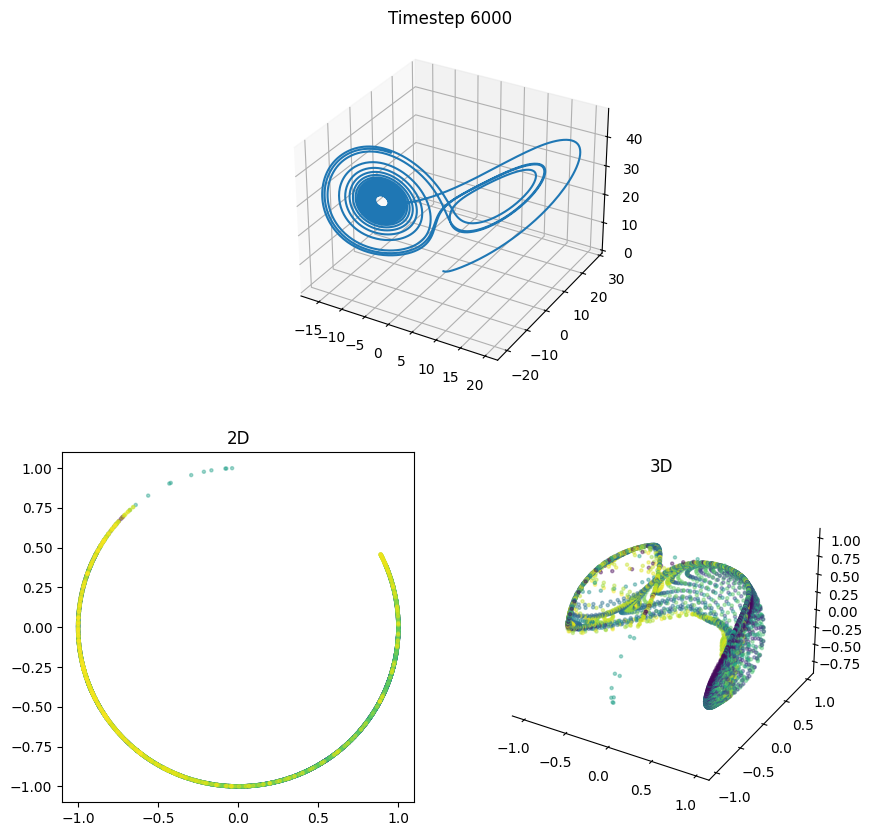

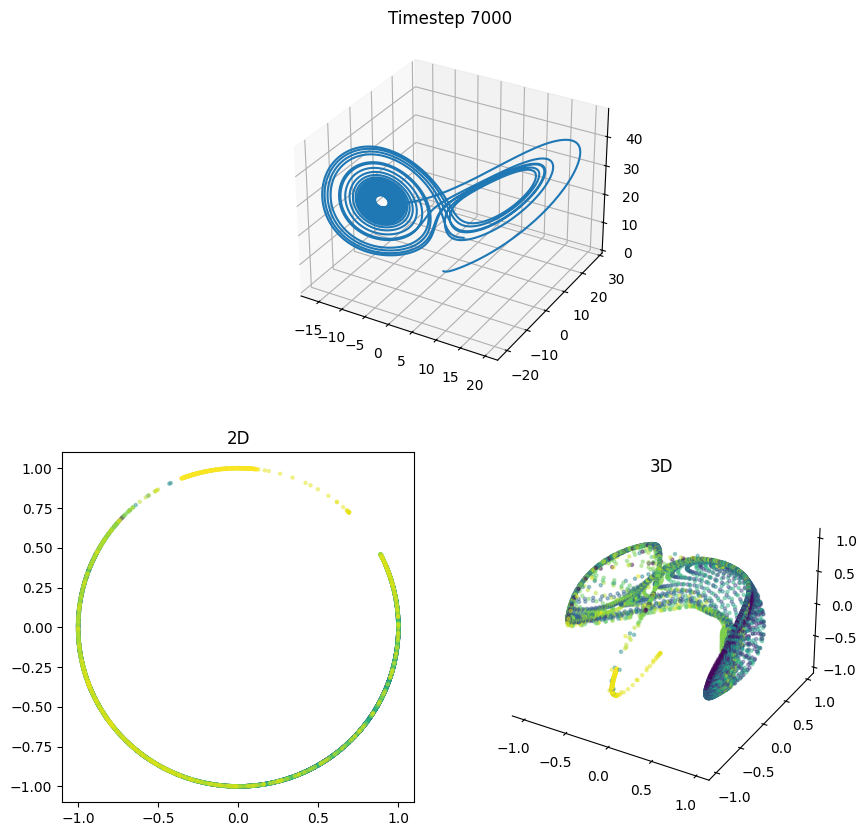

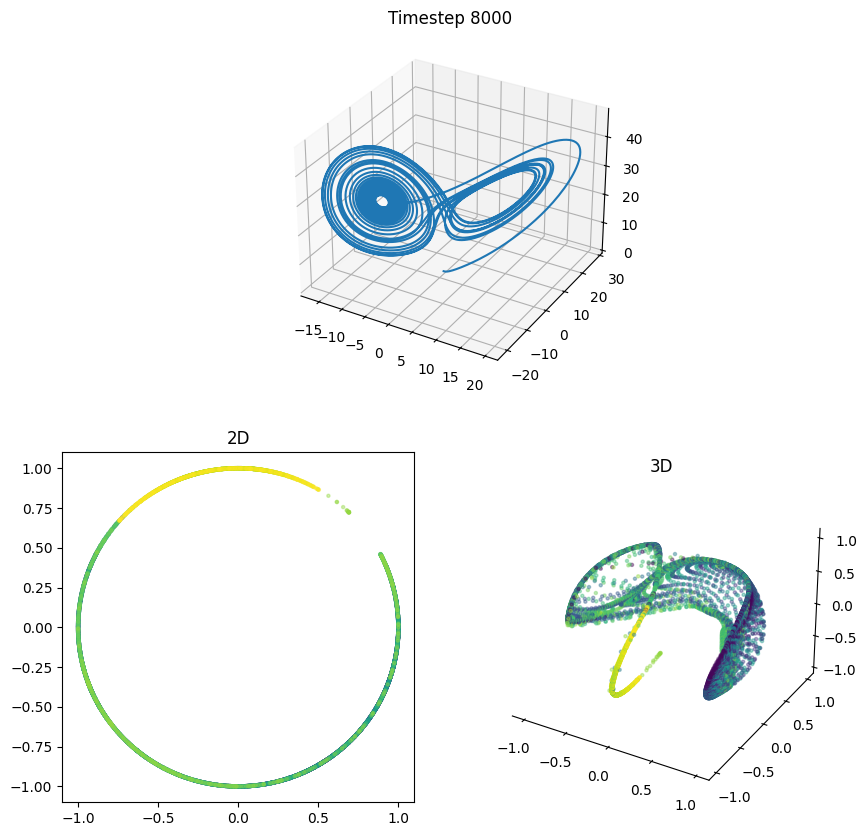

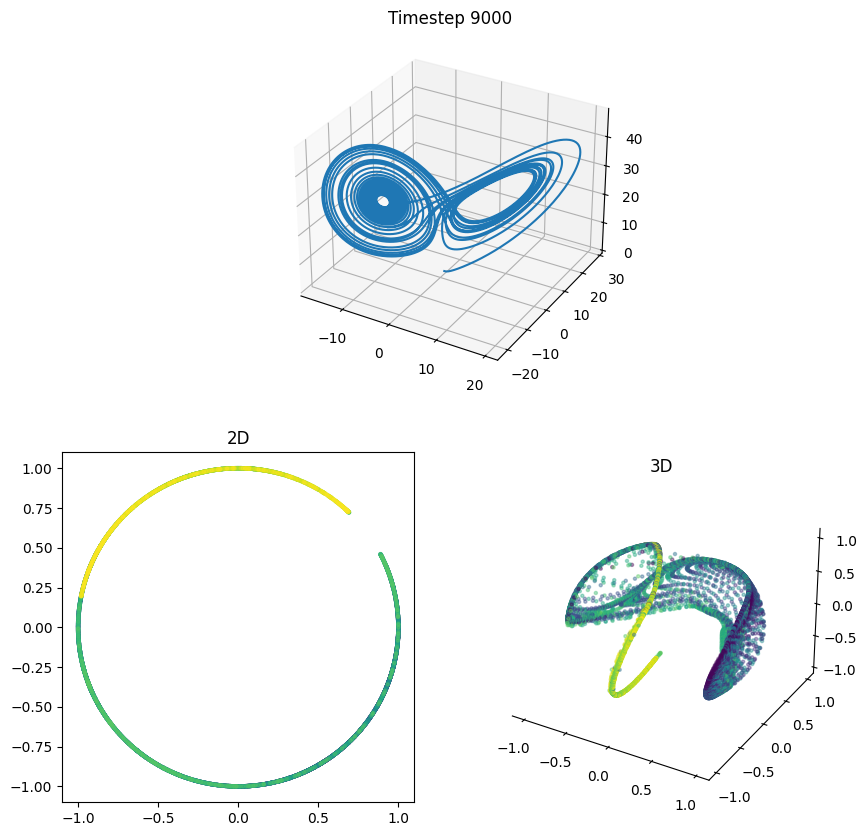

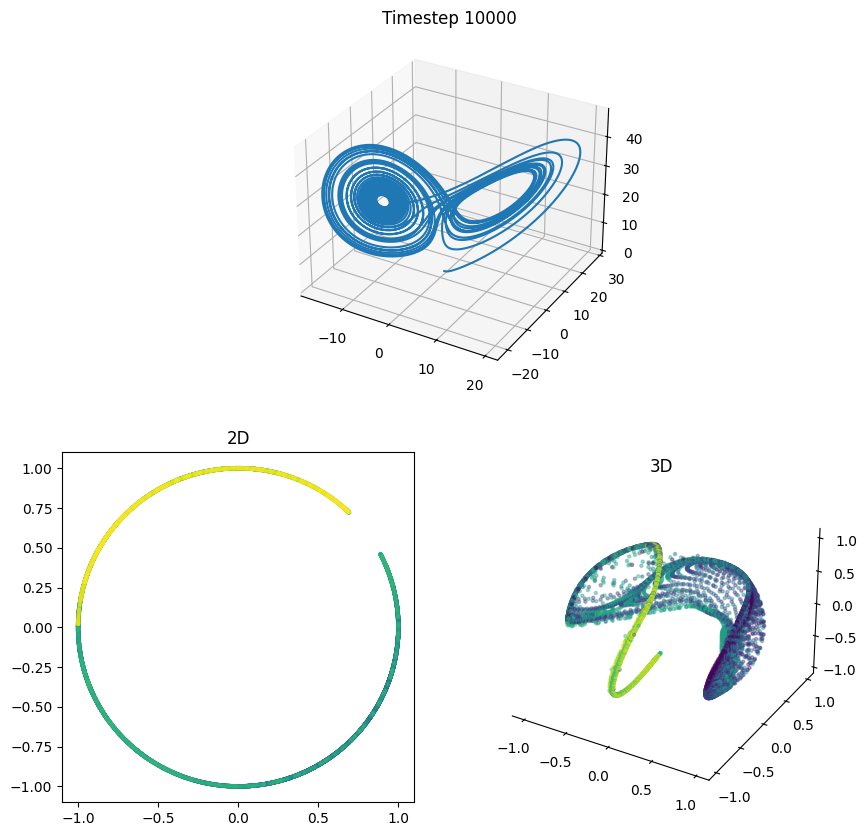

In [22]:
embed_attractor(xyz)

pos: -0.9922 neg:  6.6719 total:  5.6797 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 70.55it/s]
pos: -1.0000 neg:  7.2383 total:  6.2383 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 72.74it/s]
pos: -1.0000 neg:  7.2072 total:  6.2072 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 73.92it/s]
pos: -0.9922 neg:  6.6724 total:  5.6802 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 73.62it/s]
pos: -0.9961 neg:  7.2244 total:  6.2283 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 73.64it/s]
pos: -0.9886 neg:  6.4785 total:  5.4899 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 71.94it/s]
pos: -0.9969 neg:  6.4763 total:  5.4794 temperature:  1.0000: 100%|██████████| 1000/1000 [00:13<00:00, 72.74it/s]
pos: -0.9972 neg:  6.4741 total:  5.4769 temperature:  1.0000: 100%|██████████| 1000/1000 [00:14<00:00, 69.31it/s]
pos: -0.9946 neg:  6.4736 total:  5.4791 temperature:  1.0000: 100%|██████████| 

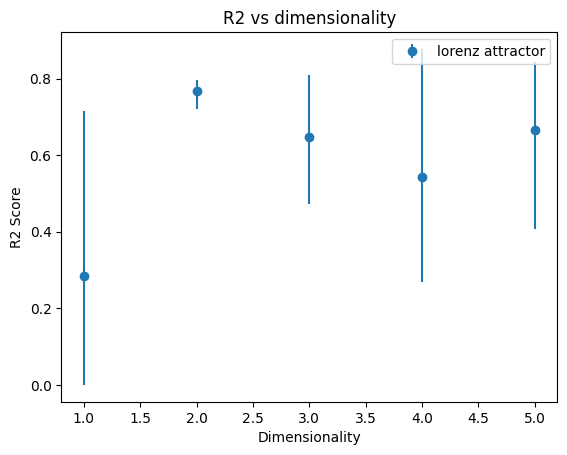

In [23]:
r2_sequence_l = dl.r2_vs_dimension(lorenz_input, dimensionality=[1,2,3,4,5], labels=['lorenz attractor'])